# Put Credit Spread (Bull Put Spread)

### I. Strategy Overview

* This strategy is composed of 2 put options:
    * Short Leg: OTM put option typically set around 20-30 delta with <30% ITM by expiration
    * Long Leg: Further OTM put option to (1) cap the maximum loss, and (2) reduce buying power requirement
* Compared to short put option, this trategy releases lots of buying powera by defining risk

#### Payoff
Option Payoff or Profit and Loss (P&L) diagrams help us understand where our options strategies win or lose money at expiration based on different stock price points.

![](put_credit_spread.jpg)

#### Features （Optional):
* Defined risk strategy (known max profit and loss)
* Long Delta: profit of the strategy increases as the underlying price goes up
* Long Theta: profit of the strategy increases as time decays
* Short volatility: profit of the strategy increases as the implied volatility drops

### II. Strategy Setup
* Observe the historical price of selected underlying
* Find avaialble expiration dates for options
* Select an expiration date, option type and stike price for the option strategy
* Select entrance and exit point (simplified by choosing future enter and exit dates)

In [1]:
import sys  
sys.path.insert(0, 'C:\\Users\\chena\\Desktop\\Trading\\StrategicOptions\\')
import datetime
from Functions.mainprg import GetDays, GetPayOff, GetBackTesting, GetPriceHistory
import pandas as pd
import numpy as np
from datetime import timedelta

Grabbing new access token...


####  a. Select underlying by ticker

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1088: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


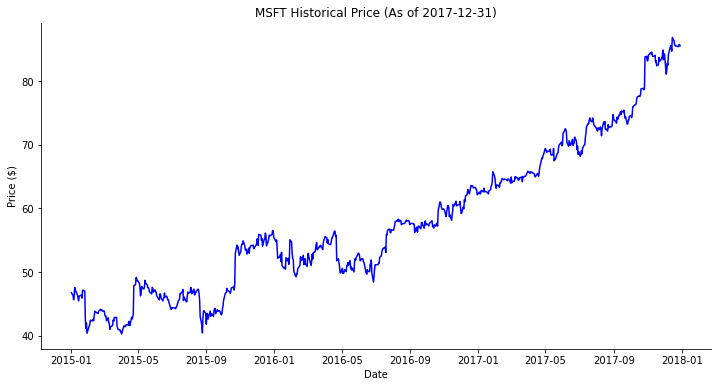

In [2]:
Ticker = 'MSFT'
GetPriceHistory(Ticker).plot_price_history()

#### b. Find expiration dates for testing period

In [3]:
Start_Date = datetime.datetime(2018, 1, 4)
End_Date = datetime.datetime(2018,6, 30)

GetDays(Ticker, Start_Date, End_Date, []).expiration_dates

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1088: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


,Expiration Date,Day of the Week,Year-Month,Expiration
0,2018-01-19,Friday,2018-01,1
1,2018-02-16,Friday,2018-02,1
2,2018-03-16,Friday,2018-03,1
3,2018-04-20,Friday,2018-04,1
4,2018-05-18,Friday,2018-05,1
5,2018-06-15,Friday,2018-06,1


#### c. Select an expiration date, choose option type (call) and strike price

In [12]:
expiration = datetime.datetime(2018, 3, 18)
option_type = ['P', 'P']  # C(all), P(ut)
action = ['L', 'S']  #L(ong), S(hort)

# Change the strike price to see how it affects the strategy
# strike_price = [85]  # At the money
strike_price = [78, 80]  # Deep in the money
#strike_price = 95  # Far out the money

#### d. Choose option enter and exit dates

In [13]:
entry_date = datetime.datetime(2018, 1, 2)
exit_date = datetime.datetime(2018, 3, 5)

### III. Visualization
#### a. Generate option(s) price and payoff

Option Premium = $0.15


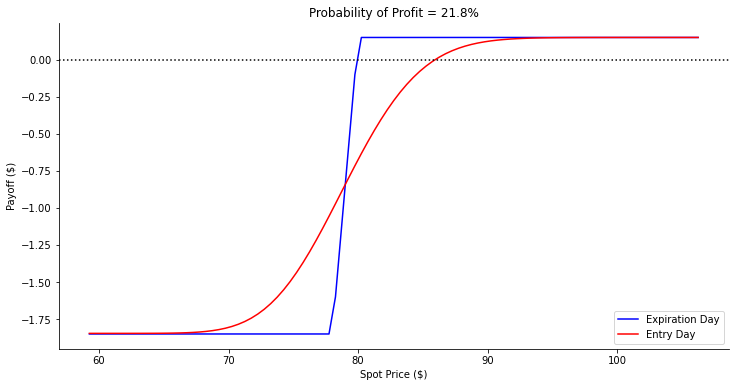

In [14]:
payoff = GetPayOff(Ticker, strike_price, entry_date, expiration, option_type, action)
print('Option Premium = '+"${:.2f}".format(payoff.option_price[1] - payoff.option_price[0]))
payoff.plot_payoff()

#### * Probability of profit here is incorrect (should be higher than short put strategy, needs more work)

##### b. Compare returns by holding the option vs. buy&hold the underlying

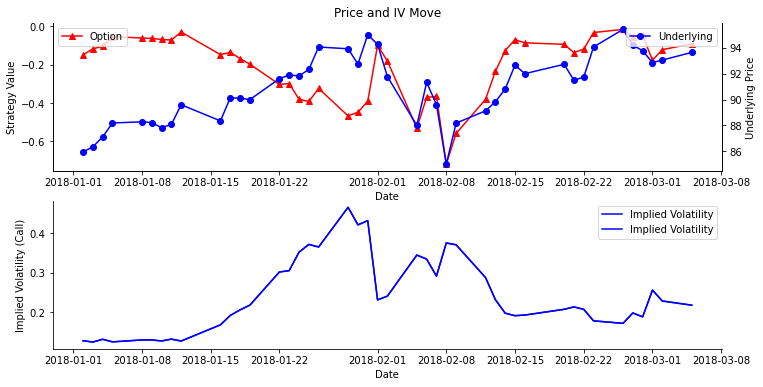

In [15]:
bt1 = GetBackTesting(Ticker, strike_price, expiration, entry_date, exit_date, option_type, action)
bt1.plot_price_history()

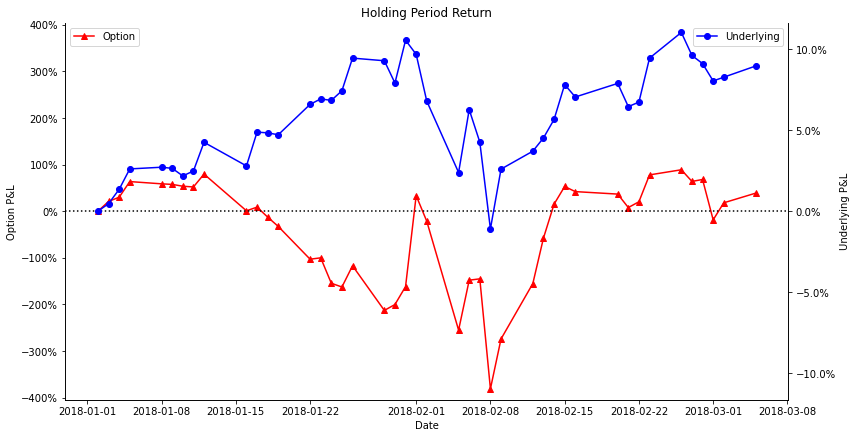

In [16]:
bt1.plot_option_pnl()

#### c. Strategy Summary

In [17]:
bt1.strategy_summary

,Entry Date,Cost Basis,Exit Date,Holding Period (Days),Residual Value,P&L,PnL/Day,ROC,Win
0,2018-01-02,$-14.94,2018-03-05,62,$-9.16,$5.78,$0.09,38.7%,True


### III. Recurring Strategy Setup

#### a. Choose the backtesting period for the recurring startegy

In [27]:
Start_Date = datetime.datetime(2016, 1, 4)
End_Date = datetime.datetime(2018,8, 30)

expiry = GetDays(Ticker, Start_Date, End_Date, []).expiration_dates
trading_days = GetDays(Ticker, Start_Date, End_Date, []).trading_days
trading_days['Year-Month'] = pd.to_datetime(trading_days['Date']).dt.to_period('M') + 1  # +1 to find the expiration date in the next month

dte_seeker = pd.merge(trading_days, expiry, on='Year-Month', how='left')
dte_seeker['DTE'] = (pd.to_datetime(dte_seeker['Expiration Date']) - pd.to_datetime(dte_seeker['Date'])).dt.days
dte_seeker.dropna(inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1088: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1088: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


#### b. Set trading rules

#### Simplified (current):
* Enter: 43 days before expriation
* Exit: 21 days before expiration
* Strike prices:
* Long leg: enter day underlying price - \\$8
* Short leg: enter day underlying price - \\$5

In [28]:
entry_dates = pd.to_datetime(dte_seeker[dte_seeker['DTE']==43]['Date'].reset_index(drop=True))
expiration_dates = pd.to_datetime(dte_seeker[dte_seeker['DTE']==43]['Expiration Date'].reset_index(drop=True))
exit_dates = entry_dates + timedelta(days=24)
expiration_dates = pd.to_datetime(expiration_dates)

#### c. Run recursive analysis

In [29]:
strategy_performance = pd.DataFrame([])
strat_sum_for_stats = []
strike_price = [32, 35]
i = 0
for _ in entry_dates:
    bt = GetBackTesting(Ticker, strike_price, expiration_dates[i], entry_dates[i], exit_dates[i], option_type, action)
    strategy_performance = strategy_performance.append(bt.strategy_summary)
    strat_sum_for_stats.append(bt.strat_sum_for_stats)
    i += 1
    end_of_period_spot = bt.underlying_price_truncated_['close'][-1]
    strike_price = [end_of_period_spot-8, end_of_period_spot-5]
    
win_rate = "{:.2%}".format(strategy_performance['Win'].sum()/len(strategy_performance['Win']))

In [30]:
win_rate

'74.19%'

In [31]:
strategy_performance.reset_index(drop=True, inplace=True)
strategy_performance

,Entry Date,Cost Basis,Exit Date,Holding Period (Days),Residual Value,P&L,PnL/Day,ROC,Win
0,2016-01-07,$-0.00,2016-01-31,24,$-0.00,$0.00,$0.00,100.0%,True
1,2016-02-04,$-80.90,2016-02-28,24,$-81.65,$-0.75,$-0.03,-0.9%,False
2,2016-03-03,$-7.26,2016-03-27,24,$-0.23,$7.02,$0.29,96.8%,True
3,2016-04-07,$-23.12,2016-05-01,24,$-84.46,$-61.34,$-2.56,-265.4%,False
4,2016-05-05,$-11.75,2016-05-29,24,$-0.10,$11.65,$0.49,99.1%,True
5,2016-06-02,$-3.32,2016-06-26,24,$-53.93,$-50.60,$-2.11,-1524.1%,False
6,2016-07-07,$-6.63,2016-07-31,24,$-0.00,$6.63,$0.28,100.0%,True
7,2016-08-04,$-2.26,2016-08-28,24,$-0.46,$1.80,$0.07,79.6%,True
8,2016-09-08,$-4.02,2016-10-02,24,$-4.34,$-0.32,$-0.01,-8.0%,False
9,2016-10-06,$-13.76,2016-10-30,24,$-1.61,$12.15,$0.51,88.3%,True


In [36]:
strategy_performance['Cost Basis']
print('Average Cost: ', "${:.2f}".format(500)) 

Average Cost:  $500.00


#### *Note that for defined risk strategies, cost = buying power effect = 100 x width between two strike prices

In [32]:
strategy_performance['P&L']
pnl_sum =strategy_performance['P&L'].str.strip('$').astype(float).sum()
print('Total Profit: ', "${:.2f}".format(pnl_sum))

Total Profit:  $161.16
